In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Fetch historical price data for BTC-USD
symbol = 'BTC-USD'
start_date = '2018-01-01'
end_date = '2022-12-31'
data = yf.download(symbol, start=start_date, end=end_date)

# Forward-fill missing data
data = data.ffill()

# Back-fill any remaining missing data
data = data.bfill()

# Drop any remaining rows with missing data
data = data.dropna()

data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


In [ ]:
!pip install ccxt
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.7/288.7 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.9 MB/s eta 0:00:00


[*********************100%%**********************]  1 of 1 completed


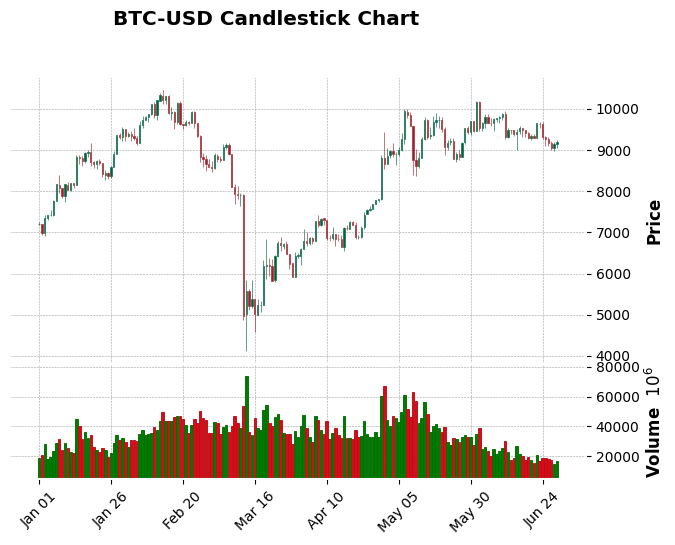

In [ ]:
import mplfinance as mpf
import matplotlib.pyplot as plt

# Define the trading period
start_date = "2020-01-01"
end_date = "2020-06-30"

# Define the symbol/ticker for Bitcoin
symbol = "BTC-USD"

# Download historical data using Yahoo Finance
data = yf.download(symbol, start=start_date, end=end_date)

# Create a DataFrame with the required columns for mplfinance
ohlc_data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Plot the candlestick chart
mpf.plot(ohlc_data, type='candle', style='charles', title=f'{symbol} Candlestick Chart', ylabel='Price', volume=True)

# Show the chart
plt.show()

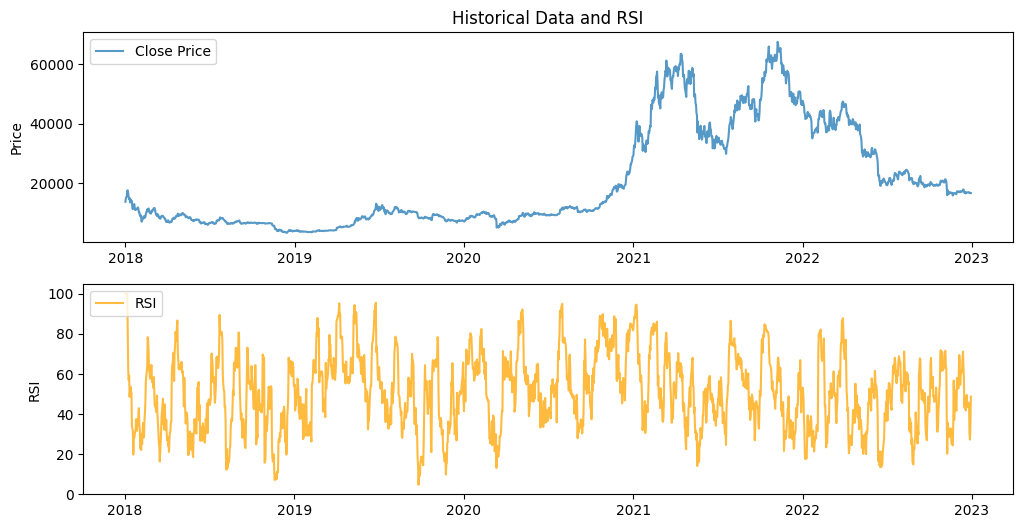

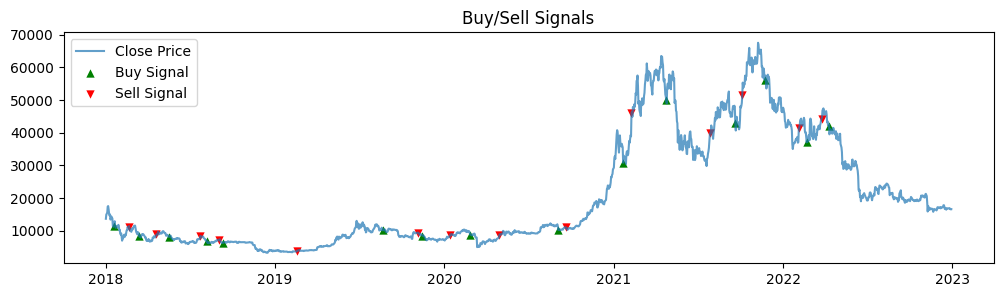

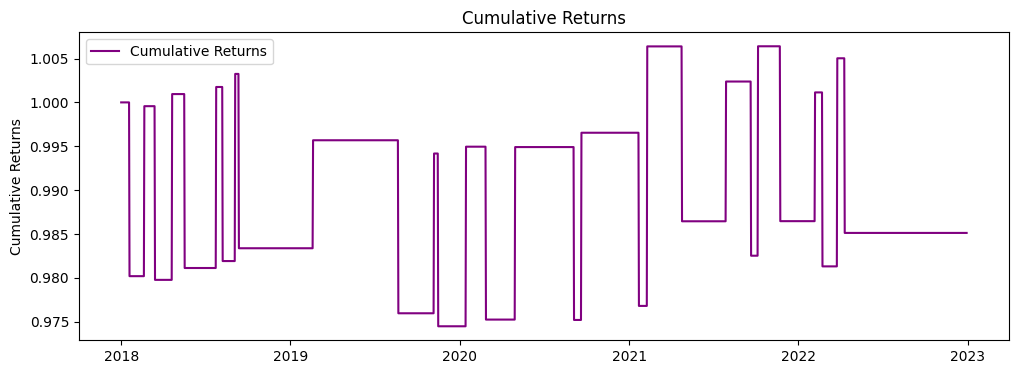

In [ ]:
# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    average_gain = gain.rolling(window=window, min_periods=1).mean()
    average_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))

    data['RSI'] = rsi
    return data

data = calculate_rsi(data)

# Define a simple trading strategy using RSI
def implement_rsi_strategy(data, overbought=75, oversold=32):
    signals = []
    in_position = False
    portfolio_value = 100000  # Initial capital in USDT
    position_size = 0.0  # Position size
    initial_balance = portfolio_value
    slippage = 0.01  # 1% slippage

    max_risk_per_trade = 0.02  # Maximum risk per trade as a percentage of portfolio value

    cumulative_returns = [1.0]  # Initialize cumulative returns with 1.0

    for i in range(len(data)):
        if data['RSI'][i] < oversold and not in_position:
            position_size = (portfolio_value * max_risk_per_trade) / (data['Close'][i] + data['Close'][i] * slippage)
            if position_size * data['Close'][i] < portfolio_value * max_risk_per_trade:
                signals.append('Buy')
                in_position = True
                portfolio_value -= position_size * data['Close'][i]
            else:
                signals.append('')
        elif data['RSI'][i] > overbought and in_position:
            signals.append('Sell')
            in_position = False
            portfolio_value += position_size * data['Close'][i]
        else:
            signals.append('')

        # Update cumulative returns for each day
        cumulative_returns.append((portfolio_value / initial_balance))

    data['Signal'] = signals

    # Calculate returns
    returns = (portfolio_value - initial_balance) / initial_balance

    return data, returns, cumulative_returns, portfolio_value

data, returns, cumulative_returns, portfolio_value = implement_rsi_strategy(data)

# Plot the historical data, RSI, and trading signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title('Historical Data and RSI')
plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)
plt.ylabel('Price')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(data.index, data['RSI'], label='RSI', color='orange', alpha=0.7)
plt.ylabel('RSI')
plt.legend(loc='upper left')

# Plot Buy/Sell signals
plt.figure(figsize=(12, 3))
plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)
buy_signal_dates = data[data['Signal'] == 'Buy'].index
sell_signal_dates = data[data['Signal'] == 'Sell'].index
plt.scatter(buy_signal_dates, data.loc[buy_signal_dates]['Close'], marker='^', color='g', label='Buy Signal', lw=0)
plt.scatter(sell_signal_dates, data.loc[sell_signal_dates]['Close'], marker='v', color='r', label='Sell Signal', lw=0)
plt.title('Buy/Sell Signals')
plt.legend(loc='upper left')

# Plot cumulative returns
plt.figure(figsize=(12, 4))
plt.plot(data.index, cumulative_returns[:len(data)], label='Cumulative Returns', color='purple')
plt.title('Cumulative Returns')
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper left')

plt.show()


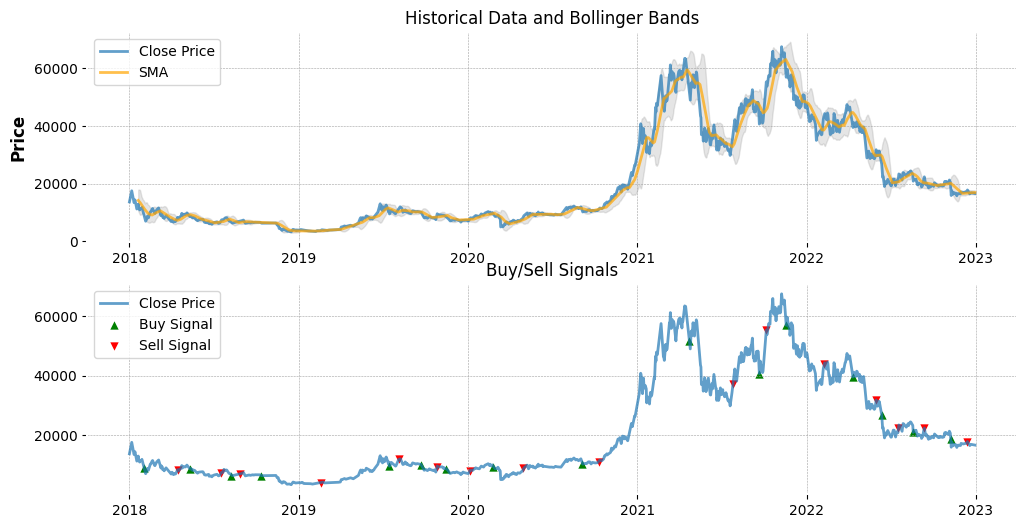

Total Returns: -1.63%
Final Portfolio Value: 98373.95 USDT


In [ ]:
# Calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, num_std_dev=2):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['Upper Band'] = data['SMA'] + (data['STD'] * num_std_dev)
    data['Lower Band'] = data['SMA'] - (data['STD'] * num_std_dev)
    return data

data = calculate_bollinger_bands(data)

# Define a simple trading strategy using Bollinger Bands with risk management
def implement_bollinger_band_strategy(data, max_risk_per_trade=0.02):
    signals = []
    in_position = False
    portfolio_value = 100000  # Initial capital in USDT
    position_size = 0.0  # Position size
    initial_balance = portfolio_value

    cumulative_returns = [1.0]  # Initialize cumulative returns with 1.0

    for i in range(len(data)):
        if data['Close'][i] < data['Lower Band'][i] and not in_position:
            position_size = (portfolio_value * max_risk_per_trade) / data['Close'][i]
            signals.append('Buy')
            in_position = True
            portfolio_value -= position_size * data['Close'][i]
        elif data['Close'][i] > data['Upper Band'][i] and in_position:
            signals.append('Sell')
            in_position = False
            portfolio_value += position_size * data['Close'][i]
        else:
            signals.append('')

        # Update cumulative returns for each day
        cumulative_returns.append((portfolio_value / initial_balance))

    data['Signal'] = signals

    # Calculate returns
    returns = (portfolio_value - initial_balance) / initial_balance

    return data, returns, cumulative_returns, portfolio_value

data, returns, cumulative_returns, portfolio_value = implement_bollinger_band_strategy(data)

# Plot the historical data, Bollinger Bands, and trading signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title('Historical Data and Bollinger Bands')
plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)
plt.plot(data.index, data['SMA'], label='SMA', color='orange', alpha=0.7)
plt.fill_between(data.index, data['Lower Band'], data['Upper Band'], color='gray', alpha=0.2)
plt.ylabel('Price')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)
buy_signal_dates = data[data['Signal'] == 'Buy'].index
sell_signal_dates = data[data['Signal'] == 'Sell'].index
plt.scatter(buy_signal_dates, data.loc[buy_signal_dates]['Close'], marker='^', color='g', label='Buy Signal', lw=0)
plt.scatter(sell_signal_dates, data.loc[sell_signal_dates]['Close'], marker='v', color='r', label='Sell Signal', lw=0)
plt.title('Buy/Sell Signals')
plt.legend(loc='upper left')

# Plot cumulative returns
plt.figure(figsize=(12, 4))
plt.plot(data.index, cumulative_returns[:len(data)], label='Cumulative Returns', color='purple')
plt.title('Cumulative Returns')
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper left')

plt.show()

# Print returns and final portfolio value
print(f"Total Returns: {returns:.2%}")
print(f"Final Portfolio Value: {portfolio_value:.2f} USDT")



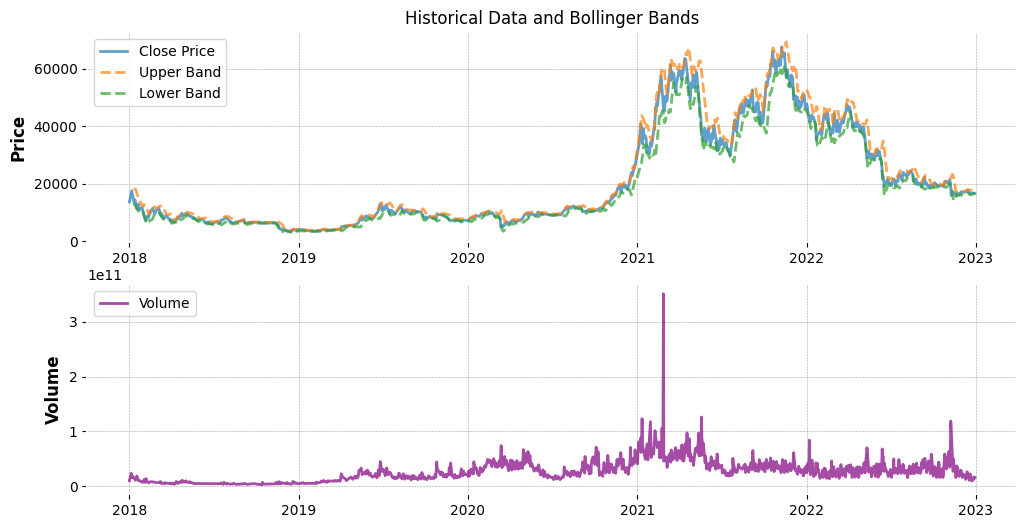

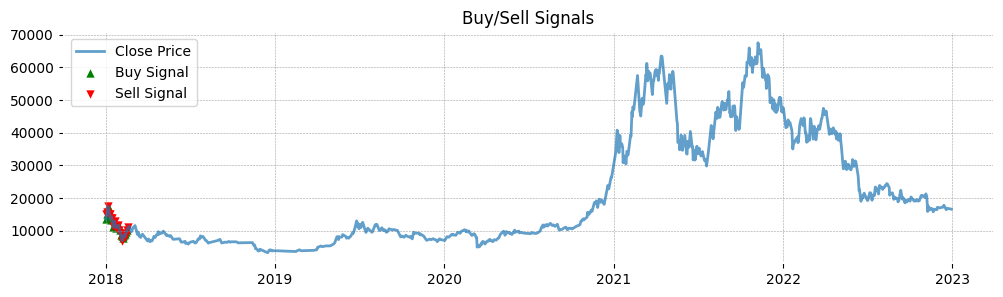

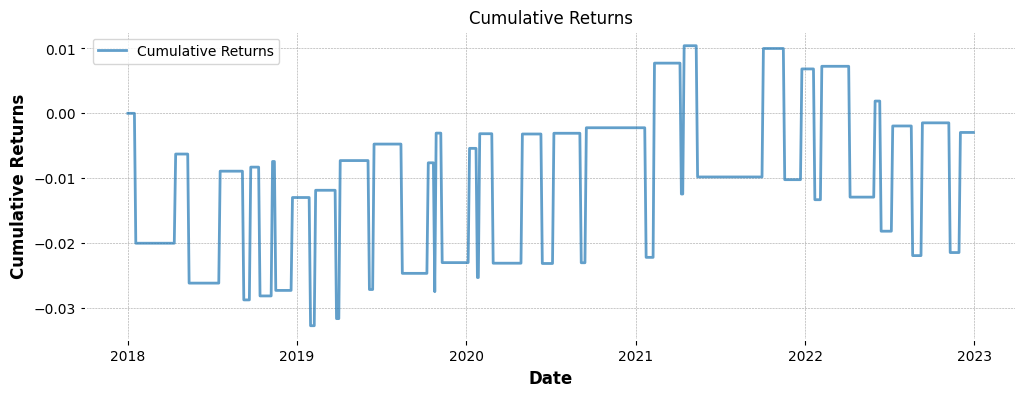

In [ ]:
# Calculate Bollinger Bands
window = 10
num_std_dev = 2

data['SMA'] = data['Close'].rolling(window=window).mean()
data['STD'] = data['Close'].rolling(window=window).std()
data['Upper Band'] = data['SMA'] + (data['STD'] * num_std_dev)
data['Lower Band'] = data['SMA'] - (data['STD'] * num_std_dev)

# Define a simple trading strategy using Bollinger Bands and volume
signals = []
in_position = False
portfolio_value = 100000  # Initial capital in USD
position_size = 0.0  # Position size
initial_balance = portfolio_value
buy_volume_threshold = 1000000  # Minimum daily trading volume for a buy signal
returns = []  # Store daily returns
cumulative_returns = []  # Store cumulative returns

for i in range(len(data)):
    if (
        data['Close'][i] < data['Lower Band'][i] and
        not in_position and
        data['Volume'][i] > buy_volume_threshold
    ):
        position_size = (portfolio_value * 0.02) / data['Close'][i]
        signals.append('Buy')
        in_position = True
        portfolio_value -= position_size * data['Close'][i]
    elif data['Close'][i] > data['Upper Band'][i] and in_position:
        signals.append('Sell')
        in_position = False
        portfolio_value += position_size * data['Close'][i]

    # Calculate daily returns
    if i > 0:
        daily_return = (portfolio_value - initial_balance) / initial_balance
        returns.append(daily_return)

    cumulative_returns.append((portfolio_value - initial_balance) / initial_balance)

# Add the last daily return (if the last position is not closed)
if in_position:
    final_daily_return = (portfolio_value - initial_balance) / initial_balance
    returns.append(final_daily_return)

# Plot the historical data, Bollinger Bands, and trading signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title('Historical Data and Bollinger Bands')
plt.plot(data['Close'], label='Close Price', alpha=0.7)
plt.plot(data['Upper Band'], label='Upper Band', alpha=0.7, linestyle='--')
plt.plot(data['Lower Band'], label='Lower Band', alpha=0.7, linestyle='--')
plt.ylabel('Price')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(data['Volume'], label='Volume', color='purple', alpha=0.7)
plt.ylabel('Volume')
plt.legend(loc='upper left')

# Plot Buy/Sell signals
plt.figure(figsize=(12, 3))
plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)
buy_indices = [i for i, signal in enumerate(signals) if signal == 'Buy']
sell_indices = [i for i, signal in enumerate(signals) if signal == 'Sell']
buy_signals = [data['Close'][i] for i in buy_indices]
sell_signals = [data['Close'][i] for i in sell_indices]
buy_dates = [data.index[i] for i in buy_indices]
sell_dates = [data.index[i] for i in sell_indices]

plt.scatter(buy_dates, buy_signals, marker='^', color='g', label='Buy Signal', lw=0)
plt.scatter(sell_dates, sell_signals, marker='v', color='r', label='Sell Signal', lw=0)
plt.title('Buy/Sell Signals')
plt.legend(loc='upper left')

# Plot Cumulative Returns
plt.figure(figsize=(12, 4))
plt.plot(data.index, cumulative_returns, label='Cumulative Returns', alpha=0.7)
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper left')

plt.show()

[*********************100%%**********************]  1 of 1 completed
Total Trades: 1170


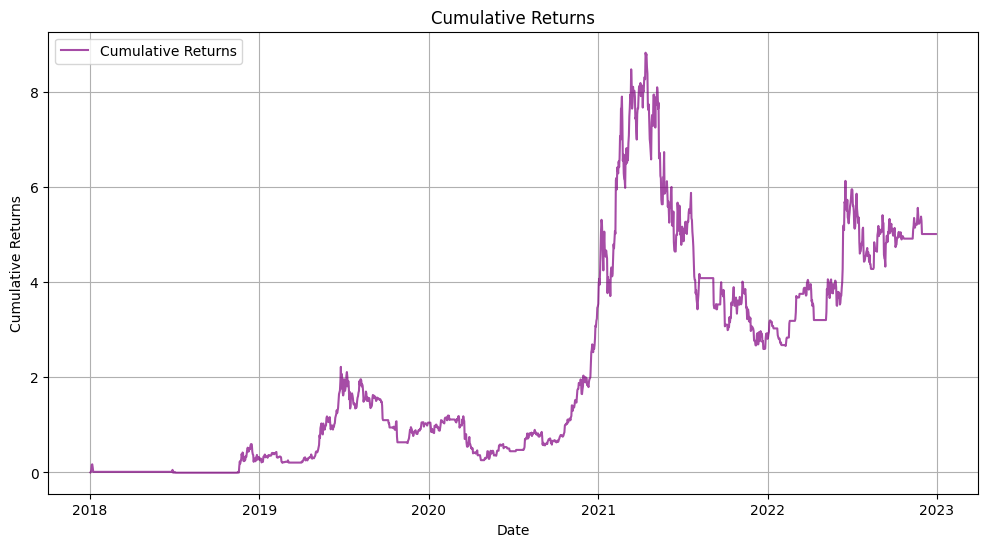

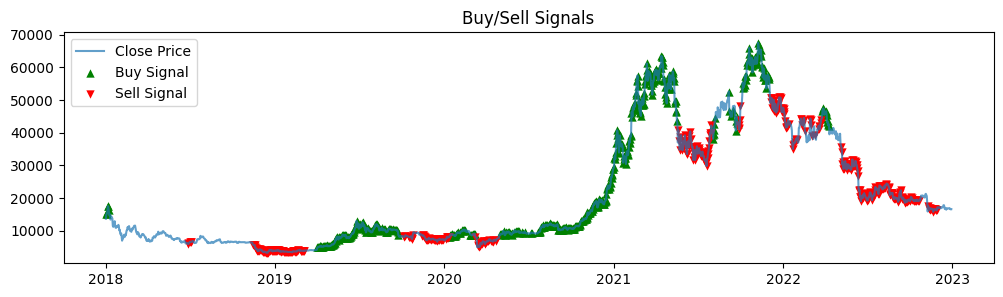

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
params = {
    'indicator_lookback': 375,
    'indicator_freq': '1m',
    'buy_signal_threshold': 0.5,
    'sell_signal_threshold': -0.5,
    'SMA_period_short': 15,
    'SMA_period_long': 60,
    'RSI_period': 60,
    'BBands_period': 300,
    'trade_freq': 1,
    'leverage': 2,
    'risk_percent': 0.02  # Maximum risk per trade (2% of capital)
}

# Define the trading period
start_date = "2018-01-01"
end_date = "2022-12-31"

# Define the symbol/ticker for the asset you want to trade
symbol = "BTC-USD"

# Download historical data using Yahoo Finance
data = yf.download(symbol, start=start_date, end=end_date)

# Function to calculate Bollinger Bands
def bollinger_band(px, period):
    rolling_mean = px.rolling(window=period).mean()
    rolling_std = px.rolling(window=period).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    return upper_band, rolling_mean, lower_band

# Function to calculate RSI
def rsi(px, period):
    delta = px.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    average_gain = gain.rolling(window=period, min_periods=1).mean()
    average_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate EMA
def ema(px, period):
    return px.ewm(span=period).mean()

# Initialize trading variables
capital = 100000  # Initial capital
position = 0      # Initial position
risk_percent = params['risk_percent']
risk_per_trade = capital * risk_percent  # Maximum risk per trade

# Initialize trading statistics
trade_count = 0
total_trades = 0
drawdown = 0
max_drawdown = 0

# Initialize equity curve
equity_curve = []

# Calculate Bollinger Bands
upper, mid, lower = bollinger_band(data['Close'], params['BBands_period'])

# Calculate indicators
ind1 = rsi(data['Close'], params['RSI_period'])
ind2 = ema(data['Close'], params['SMA_period_short'])
ind3 = ema(data['Close'], params['SMA_period_long'])

# Initialize signal array
signals = [0]

for i in range(1, len(data)):
    last_px = data['Close'][i - 1]
    dist_to_upper = 100 * (upper[i] - last_px) / (upper[i] - lower[i])

    if dist_to_upper > 80:
        signals.append(-1)
    elif dist_to_upper < 30:
        signals.append(1)
    elif ind1[i] > 75:
        signals.append(1)
    elif ind1[i] < 25:
        signals.append(-1)
    elif ind1[i] > 65 and ind2[i] - ind3[i] > 0:
        signals.append(1)
    elif ind1[i] < 35 and ind2[i] - ind3[i] < 0:
        signals.append(-1)
    elif 40 < dist_to_upper < 60 and ind2[i] - ind3[i] < 0:
        signals.append(-1)
    elif 40 < dist_to_upper < 60 and ind2[i] - ind3[i] > 0:
        signals.append(1)
    else:
        signals.append(0)

    if signals[-1] != 0:
        # Calculate position size based on risk
        position = risk_per_trade / abs(data['Close'][i])

        # Track the number of trades
        trade_count += 1

    # Calculate equity and drawdown
    equity = capital + (position * data['Close'][i])
    equity_curve.append(equity)

# Pad the signals array to match the length of the data
while len(signals) < len(data):
    signals.append(0)

data['Signal'] = signals


data['Daily Returns'] = data['Close'].pct_change() * data['Signal'].shift(1)

data['Cumulative Returns'] = (1 + data['Daily Returns']).cumprod() - 1
data['High Watermark'] = data['Cumulative Returns'].cummax()
data['Drawdown'] = data['Cumulative Returns'] - data['High Watermark']

# Display trading statistics
print(f"Total Trades: {trade_count}")

# Plot Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Cumulative Returns'], label='Cumulative Returns', alpha=0.7, color='purple')

plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper left')
plt.grid(True)

# Plot Buy/Sell signals
plt.figure(figsize=(12, 3))
plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)
buy_dates = data[data['Signal'] == 1].index
sell_dates = data[data['Signal'] == -1].index
buy_signals = data['Close'][buy_dates]
sell_signals = data['Close'][sell_dates]

plt.scatter(buy_dates, buy_signals, marker='^', color='g', label='Buy Signal', lw=0)
plt.scatter(sell_dates, sell_signals, marker='v', color='r', label='Sell Signal', lw=0)
plt.title('Buy/Sell Signals')
plt.legend(loc='upper left')

plt.show()